In [32]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import tensorflow as tf
print(tf.__version__)
import gc
#from talos.model.layers import hidden_layers
from keras import optimizers, regularizers
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LocallyConnected1D, Conv1D, Reshape
from keras.callbacks import ModelCheckpoint, History
from keras.activations import relu, elu, linear
from keras import backend as K
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split

from regression_problem import Regression
from neural_network import NeuralNetwork
from tqdm import trange

mpl.rcdefaults()
plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [10.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18

2.0.0


In [2]:
parameter_names = ["Happiness", "Economy", "Family", "Health", "Freedom", "Trust", "Generosity"]
data_df = pd.read_pickle("../data/world_happiness.pickle")[parameter_names]
data = data_df.to_numpy()
output = data[:,0].reshape(-1,1)
input_data = data[:,1:]
nr_params = input_data.shape[1]

In [ ]:
timings_self = np.zeros(20)
timings_TF = np.zeros(20)
nr_neurons_list = np.logspace(1, 4, 20, dtype=int)
nr_averages = 20

for i in trange(20):
    epochs = 1000
    nr_neurons = nr_neurons_list[i]
    

    hidden_neuron_list = [nr_neurons, nr_neurons]
    reg = Regression(hidden_activation='RELU')
    eta = 1e-3
    lmbd = 0

    X_train, X_test, Y_train, Y_test = train_test_split(input_data, output,test_size=0.3)
    Scaler = preprocessing.StandardScaler()
    X_train_scaled = Scaler.fit_transform(X_train)
    X_test_scaled = Scaler.transform(X_test)

    t0 = time.time()
    for j in range(nr_averages):
        nn = NeuralNetwork( X_train_scaled,
                            Y_train,
                            problem=reg,
                            n_hidden_neurons_list=hidden_neuron_list,
                            n_output_neurons=1,
                            epochs=epochs,
                            batch_size=32,
                            eta=eta,
                            lmbd=lmbd,
                            debug=False)
        nn.SGD(track=False)
    timings_self[i] = (time.time() - t0)/nr_averages

    
    t0 = time.time()
    for j in range(nr_averages):
        opti = optimizers.SGD(lr=1e-3)
        def nn_reg():
            model = Sequential()
            model.add(Dense(nr_neurons, input_shape=(nr_params,), activation="relu", kernel_initializer='random_normal'))
            model.add(Dense(nr_neurons, activation="relu", kernel_initializer='random_normal'))
            model.add(Dense(1, activation="linear", kernel_initializer='random_normal'))
            model.compile(optimizer=opti, loss="mean_squared_error")
            return model
        reg = KerasRegressor(build_fn=nn_reg, batch_size=32, epochs=epochs, validation_data=(X_test_scaled, Y_test), verbose=0)
        reg.fit(X_train_scaled, Y_train)
    timings_TF[i] = (time.time() - t0)/nr_averages
    
    print(timings_self, timings_TF)

In [37]:
np.save("../data/timings_self.npy", timings_self)
np.save("../data/timings_TF.npy", timings_TF)
np.save("../data/timings_neurons.npy", nr_neurons_list)

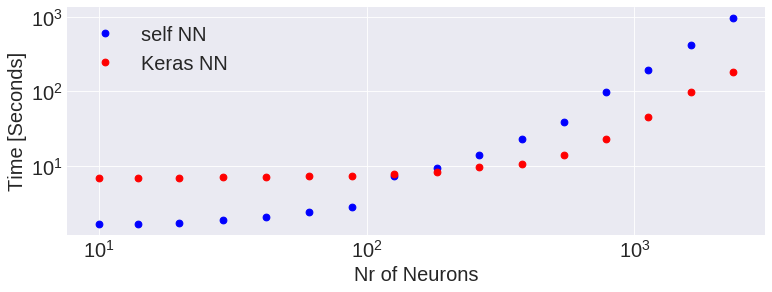

In [39]:
plt.loglog(nr_neurons_list, timings_self, "bo", label="self NN")
plt.loglog(nr_neurons_list, timings_TF, "ro", label="Keras NN")
plt.xlabel("Nr of Neurons")
plt.ylabel("Time [Seconds]")
plt.legend();
plt.tight_layout()
plt.savefig("../figs/timings.pdf", bbox_inches="tight");